In [4]:
# https://www.kaggle.com/code/nageshsingh/stock-market-forecasting-arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

import yfinance as yf
from datetime import datetime

<ipython-input-4-45ebfbba0953>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


[*********************100%%**********************]  1 of 1 completed


Dataset length- 653  | Training len- 647  | Default prediction len- 6  | Custom Prediction len- 5


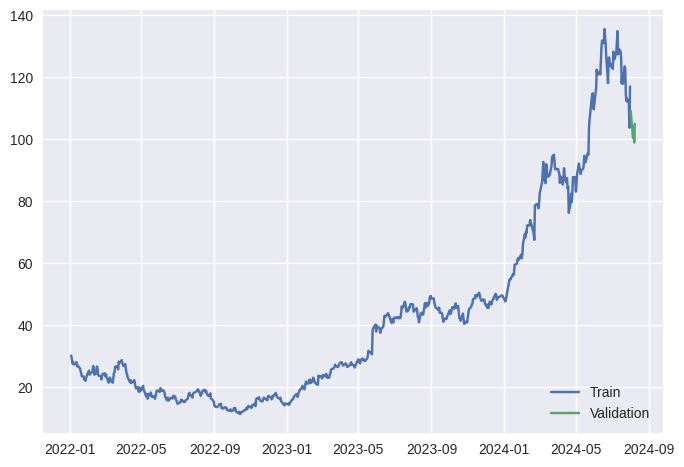

In [30]:
prediction_data_len =5
start_date = '2022-01-01'
end_date = datetime.now()
df_detail = yf.download("NVDA", start_date, end_date)

#sns.lineplot(df_detail, x='Date', y='Close')
data = df_detail.filter(['Close'])
training_data_len = int(np.ceil( len(data) * 0.99 ))   # set train len to 1 for pred

print('Dataset length-', len(data), ' | Training len-', training_data_len, ' | Default prediction len-', len(data)-training_data_len, ' | Custom Prediction len-', prediction_data_len)
train_data = data.iloc[0:int(training_data_len), :]
val_data = data.iloc[training_data_len: , :]

plt.plot(train_data['Close'])
plt.plot(val_data[['Close']])
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

<Axes: ylabel='Density'>

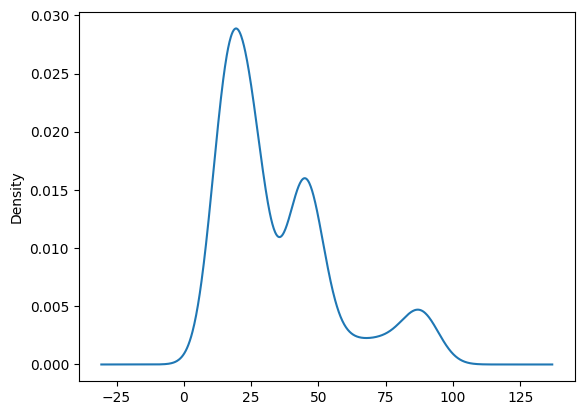

In [ ]:
#Distribution of the dataset
train_data['Close'].plot(kind='kde')

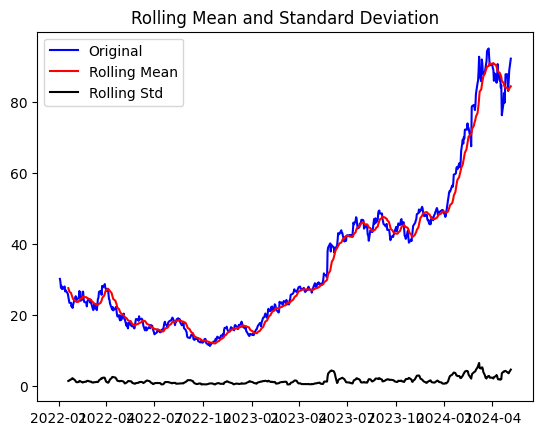

Results of dickey fuller test
Test Statistics                  2.087514
p-value                          0.998776
No. of lags used                 2.000000
Number of observations used    585.000000
critical value (1%)             -3.441578
critical value (5%)             -2.866493
critical value (10%)            -2.569408
dtype: float64


In [ ]:
#Test for staionarity
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(train_data['Close'])

#Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.
#We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

<ipython-input-29-b22d6863b794>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<Figure size 800x550 with 0 Axes>

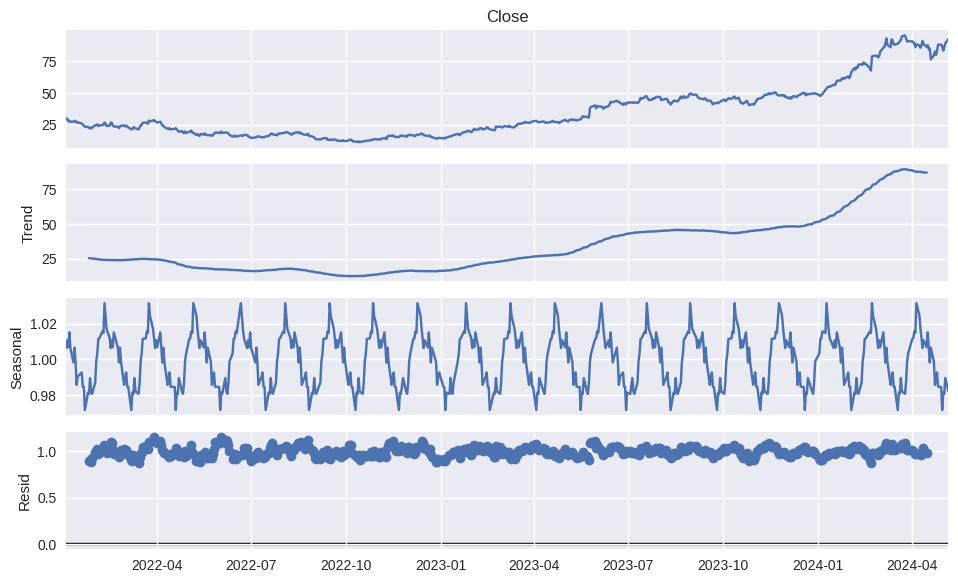

In [ ]:

#from pylab import rcParams
#rcParams['figure.figsize'] = 6, 3

#To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_data['Close'], model='multiplicative' , period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(10, 6)

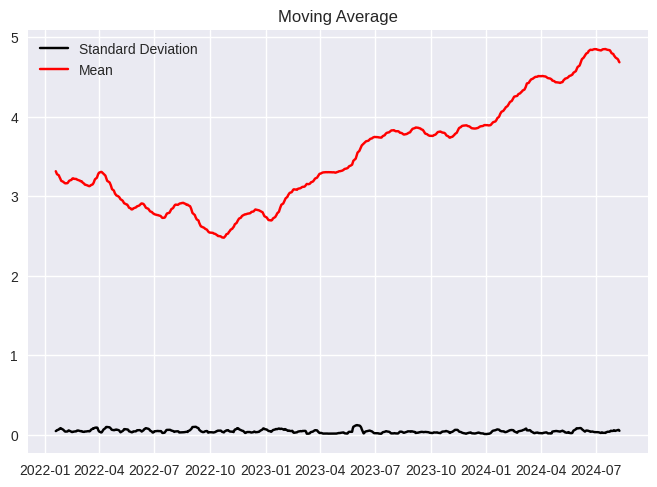

In [ ]:
df_log = np.log(df_detail['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1975.715, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1977.655, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1977.636, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1977.594, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1976.056, Time=1.44 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.405 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  588
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -985.858
Date:                Thu, 08 Aug 2024   AIC                           1975.715
Time:                        23:07:55   BIC                           1984.465
Sample:                             0   HQIC                          1979.125
                                - 588                                       

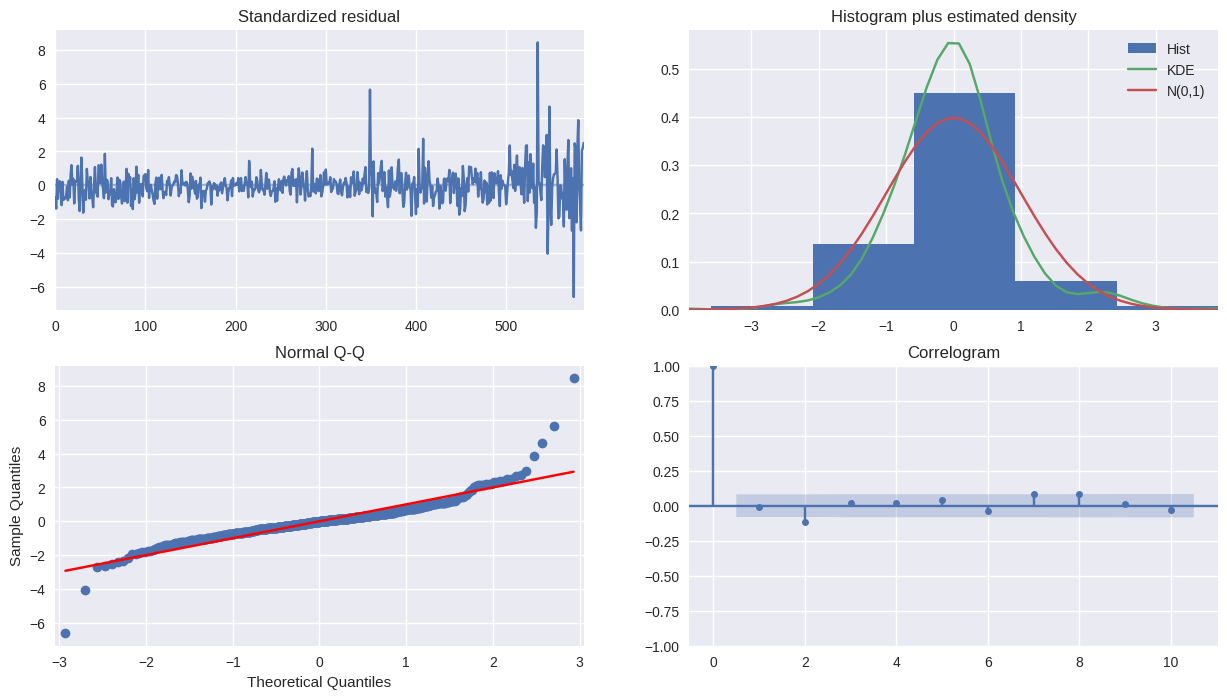

In [ ]:
#!pip install pmdarima
from pmdarima.arima import auto_arima
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.8 MB/s eta 0:00:00


In [31]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(5,1,2))
fitted = model.fit()
print(fitted.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  647
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -1285.939
Date:                Fri, 09 Aug 2024   AIC                           2587.877
Time:                        00:15:15   BIC                           2623.644
Sample:                             0   HQIC                          2601.754
                                - 647                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5339      0.235     -6.523      0.000      -1.995      -1.073
ar.L2         -0.8259      0.169     -4.894      0.000      -1.157      -0.495
ar.L3         -0.1574      0.060     -2.606      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


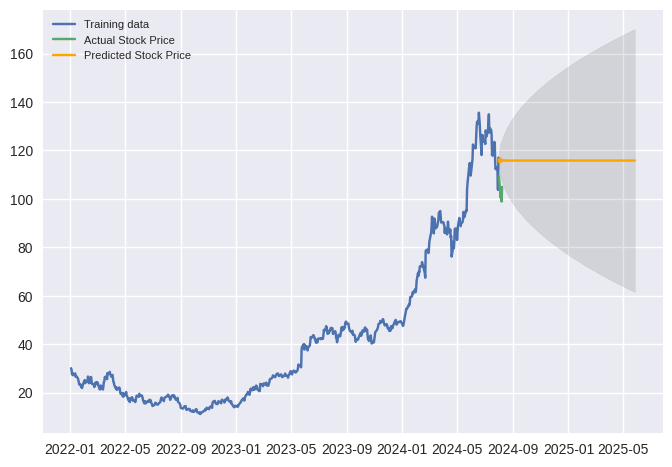

In [32]:
# Forecast with confidence intervals
forecast = fitted.get_forecast(steps=300)
conf_int = forecast.conf_int(alpha=.05)  # 95% confidence interval

# Extract the forecasted values and confidence intervals
fc = forecast.predicted_mean
lower_series = conf_int.iloc[:, 0]
upper_series = conf_int.iloc[:, 1]

# Convert to pandas Series
start_date = train_data.index.max() + pd.Timedelta(days=1)
date_index = pd.date_range(start=start_date, periods=len(fc), freq='D')

fc_series = pd.Series(pd.array(fc), index=date_index)
lower_series = pd.Series(pd.array(lower_series), index=date_index)
upper_series = pd.Series(pd.array(upper_series), index=date_index)

# Plot
plt.plot(train_data, label='Training data')
plt.plot(val_data, label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
lower_series
conf_int

,lower Close,upper Close
588,89.513060,94.538639
589,88.166845,95.232893
590,87.958274,96.245792
591,87.563072,96.963211
592,87.418062,97.837720
...,...,...
648,80.840273,127.295677
649,80.711645,127.742986
650,80.621172,128.226345
651,80.492475,128.672807
